# FER with ResNet50

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import *

## Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/fer.csv')

## EDA

In [5]:
df.head()

,emotion,pixels
0,1,204 206 200 104 71 77 112 170 193 204 218 223 ...
1,1,19 21 27 28 33 29 41 37 24 31 42 45 48 62 63 7...
2,1,223 245 233 243 243 243 244 244 248 245 218 21...
3,1,119 30 120 166 119 101 108 91 51 58 68 82 100 ...
4,1,76 93 103 96 99 103 103 120 134 138 149 150 14...


In [6]:
df.shape

(17978, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17978 entries, 0 to 17977
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  17978 non-null  int64 
 1   pixels   17978 non-null  object
dtypes: int64(1), object(1)
memory usage: 281.0+ KB


In [8]:
df.emotion.value_counts()

1    8989
0    8989
Name: emotion, dtype: int64

## Pre-processing

### Formatting

In [9]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [10]:
img_array.shape

(17978, 48, 48, 1)

### Grayscale to rgb 

In [11]:
rgb_array = np.repeat(img_array, 3, axis=-1)

In [12]:
rgb_array.shape

(17978, 48, 48, 3)

### Formatting label values for model

In [13]:
img_labels = df.emotion.values

In [14]:
img_labels.shape

(17978,)

## Splitting the data into training and testing set

In [15]:
X_train, X_test, y_train, y_test = train_test_split(rgb_array, 
                                                    img_labels,
                                                    test_size=0.1, 
                                                    shuffle=True,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.1, 
                                                  random_state=42)

In [16]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("\n")
print("X_val shape: {}".format(X_val.shape))
print("y val shape: {}".format(y_val.shape))
print("\n")
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (14562, 48, 48, 3)
y_train shape: (14562,)


X_val shape: (1618, 48, 48, 3)
y val shape: (1618,)


X_test shape: (1798, 48, 48, 3)
y_test shape: (1798,)


In [17]:
print(np.round(((X_train.shape[0]) / (img_array.shape[0]))*100), "% of Train set")
print(np.round(((X_val.shape[0]) / (img_array.shape[0]))*100), "% of Validation set")
print(np.round(((X_test.shape[0]) / (img_array.shape[0]))*100), "% of Test set")

81.0 % of Train set
9.0 % of Validation set
10.0 % of Test set


## Image Properties

In [18]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]

In [19]:
print("The following are the image properties :")
print("   Width =", img_width)
print("   Height =", img_height)
print("   Depth =", img_depth)

The following are the image properties :
   Width = 48
   Height = 48
   Depth = 3



## Normalization

In [20]:
X_train = X_train / 255.

X_val = X_val / 255.

X_test = X_test / 255.

## ResNet-50

In [21]:
resnet50 = Sequential()

resnet50.add(ResNet50(input_shape=(48,48,3), include_top=False, weights='imagenet', pooling='max'))

resnet50.add(Dense(1, activation='sigmoid'))

94765736/94765736 [==============================] - 3s 0us/step


In [22]:
resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Model Summary

In [23]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 32.6 MB/s eta 0:00:00


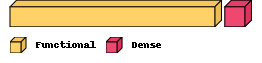

In [24]:
import visualkeras
visualkeras.layered_view(resnet50, legend=True, draw_volume=True, draw_funnel=False)

In [25]:
resnet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


## Model Training

In [26]:
resnet50_history = resnet50.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
456/456 [==============================] - 89s 55ms/step - loss: 0.8113 - accuracy: 0.7598 - val_loss: 0.7235 - val_accuracy: 0.5111
Epoch 2/10
456/456 [==============================] - 23s 51ms/step - loss: 0.4627 - accuracy: 0.8131 - val_loss: 0.4677 - val_accuracy: 0.7954
Epoch 3/10
456/456 [==============================] - 23s 51ms/step - loss: 0.2963 - accuracy: 0.8800 - val_loss: 0.3052 - val_accuracy: 0.8646
Epoch 4/10
456/456 [==============================] - 23s 50ms/step - loss: 0.2085 - accuracy: 0.9163 - val_loss: 0.3045 - val_accuracy: 0.8708
Epoch 5/10
456/456 [==============================] - 23s 51ms/step - loss: 0.1774 - accuracy: 0.9346 - val_loss: 0.3087 - val_accuracy: 0.8869
Epoch 6/10
456/456 [==============================] - 24s 53ms/step - loss: 0.1188 - accuracy: 0.9548 - val_loss: 2.1134 - val_accuracy: 0.6199
Epoch 7/10
456/456 [==============================] - 22s 49ms/step - loss: 0.4935 - accuracy: 0.7947 - val_loss: 0.4586 - val_accuracy:

## Result Plots

In [27]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "train_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "train_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")   
    plt.legend()
    
    plt.tight_layout()

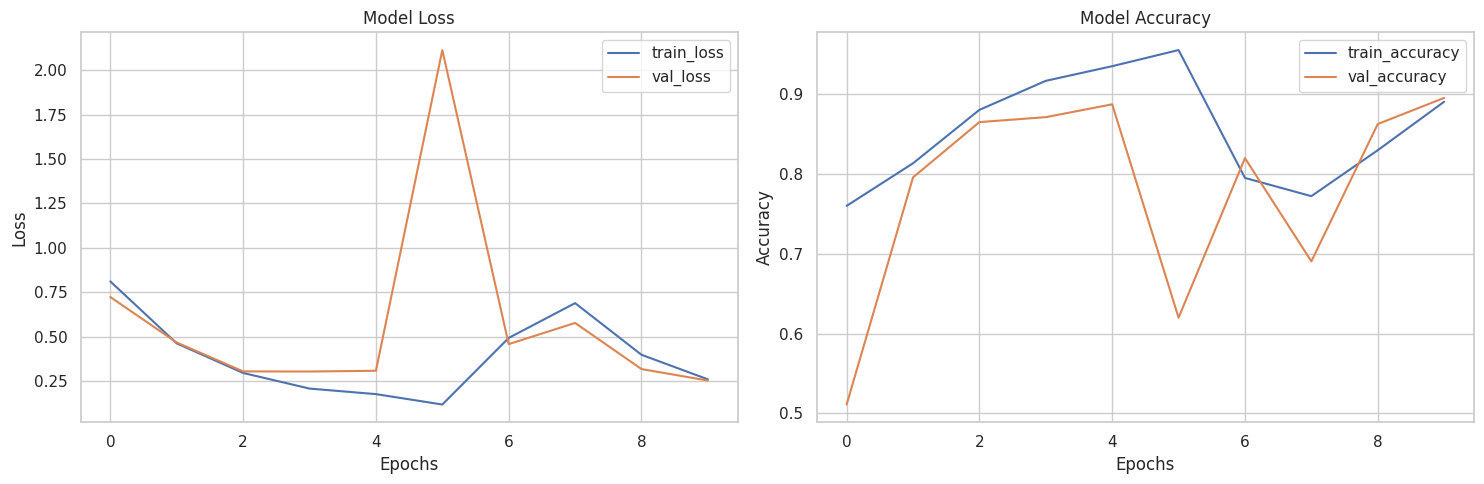

In [28]:
plot_curves(resnet50_history)

# Model Evaluation

In [29]:
train_loss, train_accuracy = resnet50.evaluate(X_train, y_train)
print("Train loss = {:.2f}".format(train_loss))
print("Train accuracy = {:.2f}%".format(train_accuracy*100))

456/456 [==============================] - 6s 13ms/step - loss: 0.1863 - accuracy: 0.9299
Train loss = 0.19
Train accuracy = 92.99%


In [30]:
val_loss, val_accuracy = resnet50.evaluate(X_val, y_val)
print("Validation loss = {:.2f}".format(val_loss))
print("Validation accuracy = {:.2f}%".format(val_accuracy*100))

51/51 [==============================] - 1s 15ms/step - loss: 0.2537 - accuracy: 0.8949
Validation loss = 0.25
Validation accuracy = 89.49%


In [31]:
val_pred = resnet50.predict(X_val)
y_val_pred = np.where(val_pred > 0.5, 1, 0)

51/51 [==============================] - 2s 13ms/step


Resnet50 Model Confusion Matrix


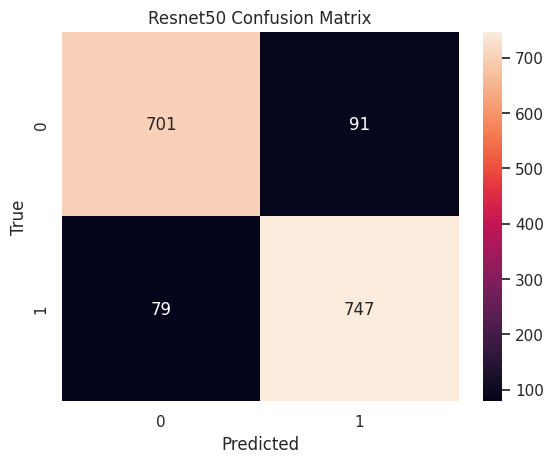

In [32]:
print('Resnet50 Model Confusion Matrix')

cm = tf.math.confusion_matrix(y_val, y_val_pred, num_classes=2, dtype=tf.dtypes.int32)

sns.heatmap(cm, annot=True, fmt="d")

plt.title('Resnet50 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

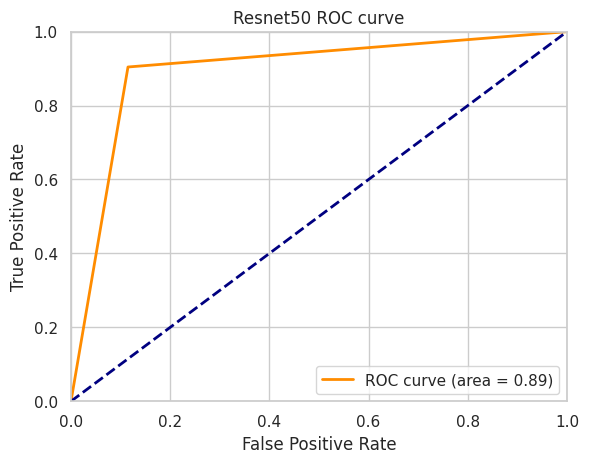

In [33]:
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Resnet50 ROC curve')
plt.legend(loc="lower right")
plt.show()

### Evaluation on Test Set

In [34]:
loss, accuracy = resnet50.evaluate(X_test, y_test)
print("Loss = {:.2f}".format(loss))
print("Accuracy = {:.2f}%".format(accuracy*100))

57/57 [==============================] - 1s 22ms/step - loss: 0.2386 - accuracy: 0.9027
Loss = 0.24
Accuracy = 90.27%


In [35]:
pred = resnet50.predict(X_test)
y_pred = np.where(pred > 0.5, 1, 0)

57/57 [==============================] - 1s 13ms/step


In [36]:
print('Classification Report for Test set:')
print(classification_report(y_test, y_pred))

Classification Report for Test set:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       901
           1       0.90      0.91      0.90       897

    accuracy                           0.90      1798
   macro avg       0.90      0.90      0.90      1798
weighted avg       0.90      0.90      0.90      1798



In [37]:
acc = accuracy_score(y_test, y_pred)

prec = precision_score(y_test, y_pred)

rec = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.2f} \nPrecision: {prec:.2f} \nRecall: {rec:.2f}")

Accuracy: 0.90 
Precision: 0.90 
Recall: 0.91


`ResNet50 Model for FER`